In [ ]:
! pip install torch transformers datasets scikit-learn accelerate

In [1]:
import os
import glob
import random
import torch
import numpy as np
os.environ["HF_DATASETS_CACHE"] = "/ssd_2t_1/wyq_workspace/hf_cache"
# 建议同时也设置 transformers 的缓存，防止模型下载到默认路径
os.environ["HF_HOME"] = "/ssd_2t_1/wyq_workspace/hf_cache"
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    Seq2SeqTrainer, 
    Seq2SeqTrainingArguments, 
    DataCollatorForSeq2Seq
)

# 强制只使用 GPU 0 (3090)
# 或者你可以设置为 "2" 使用另一张 3090
# 或者设置为 "0,2" 同时使用两张 (但这需要多卡并行代码，暂时先用单卡最稳)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 再次确认
import torch
if torch.cuda.is_available():
    print(f"当前使用的显卡: {torch.cuda.get_device_name(0)}")
    print(f"显存总量: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("未检测到 GPU")

# ================= 配置参数 =================
# 论文选用的基座模型：CodeT5p 770M (Encoder-Decoder) 
MODEL_NAME = "Salesforce/codet5p-770m"

# 您的数据路径
# DATA_DIR = "/home/wyq/GenKubeSec_Reproduce/raw_100_yaml_files"

# 论文限制：CodeT5p 770M 的最大 Token 为 512 
MAX_LENGTH = 512

# 论文设定：Masking 比例为 15% 
MASK_RATIO = 0.15

# 输出目录
OUTPUT_DIR = "/ssd_2t_1/wyq_workspace/genkubesect_structural_model"

# 训练参数 (根据您的显存调整，RTX 4090 可以尝试 batch_size=4 或 8)
BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 2e-5
SEED = 42
GRADIENT_ACCUMULATION_STEPS = 2

# 设置随机种子以复现结果
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
# print(f"配置完成。数据目录: {DATA_DIR}")

当前使用的显卡: NVIDIA GeForce RTX 3090
显存总量: 23.56 GB


In [2]:
from datasets import load_dataset
import os
os.environ["http_proxy"] = "http://127.0.0.1:36217"
os.environ["https_proxy"] = "http://127.0.0.1:36217"
# ================= 数据集配置 =================
# 目标数据集
DATASET_NAME = "substratusai/the-stack-yaml-k8s"

# 并行处理的进程数 (根据您的 CPU 核心数调整，建议设为 8 或 16)
NUM_PROC = 16 

def load_kcf_dataset():
    """
    从 Hugging Face Hub 加载大规模 KCF 数据集。
    """
    print(f"正在加载数据集: {DATASET_NAME} ...")
    
    # split="train" 加载训练集
    # 如果您的网络不稳定，可以加上 streaming=True，但为了训练速度建议先下载完
    try:
        dataset = load_dataset(DATASET_NAME, split="train")
        print(f"数据集加载成功！总样本数: {len(dataset)}")
        
        # 检查列名，该数据集通常将代码存储在 'content' 列
        print(f"数据列名: {dataset.column_names}")
        return dataset
    except Exception as e:
        print(f"加载失败，请检查网络或 Hugging Face 连接: {e}")
        return None

# 执行加载
raw_dataset = load_kcf_dataset()

# 检查一条数据看看长什么样
if raw_dataset:
    print("\n=== 样本预览 ===")
    print(raw_dataset[0]['content'][:200])

正在加载数据集: substratusai/the-stack-yaml-k8s ...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00005-d8eb364753f195(…):   0%|          | 0.00/60.8M [00:00<?, ?B/s]

data/train-00001-of-00005-eff6b89c1b28b7(…):   0%|          | 0.00/64.3M [00:00<?, ?B/s]

data/train-00002-of-00005-40aa9aee0bc870(…):   0%|          | 0.00/62.6M [00:00<?, ?B/s]

data/train-00003-of-00005-f5f534908543f0(…):   0%|          | 0.00/62.7M [00:00<?, ?B/s]

data/train-00004-of-00005-ddc2f0289becc7(…):   0%|          | 0.00/62.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/276520 [00:00<?, ? examples/s]

数据集加载成功！总样本数: 276520
数据列名: ['hexsha', 'size', 'ext', 'lang', 'max_stars_repo_path', 'max_stars_repo_name', 'max_stars_repo_head_hexsha', 'max_stars_repo_licenses', 'max_stars_count', 'max_stars_repo_stars_event_min_datetime', 'max_stars_repo_stars_event_max_datetime', 'max_issues_repo_path', 'max_issues_repo_name', 'max_issues_repo_head_hexsha', 'max_issues_repo_licenses', 'max_issues_count', 'max_issues_repo_issues_event_min_datetime', 'max_issues_repo_issues_event_max_datetime', 'max_forks_repo_path', 'max_forks_repo_name', 'max_forks_repo_head_hexsha', 'max_forks_repo_licenses', 'max_forks_count', 'max_forks_repo_forks_event_min_datetime', 'max_forks_repo_forks_event_max_datetime', 'content', 'avg_line_length', 'max_line_length', 'alphanum_fraction']

=== 样本预览 ===
#
# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements.  See the NOTICE file
# distributed with this work for additional information
# regarding copyri


In [ ]:
! pip install --upgrade ipywidgets

In [3]:
os.environ["http_proxy"] = "http://127.0.0.1:36217"
os.environ["https_proxy"] = "http://127.0.0.1:36217"

# 可选：在加载大模型前做一个快速的网络连通性检查
import time
try:
    import requests
except Exception:
    requests = None

hf_check_url = "https://huggingface.co"
if requests is not None:
    try:
        print(f"检查网络连通性：{hf_check_url} (timeout=5s) ...")
        r = requests.head(hf_check_url, timeout=5)
        print(f"网络可达，状态码：{r.status_code}")
    except Exception as e:
        print("无法访问 huggingface.co（可能网络或代理问题）。尝试继续，但加载可能会阻塞或失败：", e)
else:
    print("未检测到 requests 库，跳过网络连通性快速检查。")

# 初始化 Tokenizer（记录加载时间以便判断是否卡住）
print(f"开始加载 tokenizer: {MODEL_NAME}")
t0 = time.time()
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
t1 = time.time()
print(f"tokenizer 加载完成，耗时: {t1 - t0:.1f}s")

# 确保 Tokenizer 已加载
if 'tokenizer' not in locals():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    if not tokenizer.mask_token:
        tokenizer.mask_token = "<mask>"

def prepare_structural_tasks(examples):
    inputs = []
    targets = []
    
    # -----------------------------------------------------------
    # 修改点：该数据集的内容列名为 'content'，而不是之前的 'text'
    # -----------------------------------------------------------
    contents = examples['content'] 
    
    for content in contents:
        # 跳过空内容
        if not content or not isinstance(content, str):
            continue
            
        # 1. 初始 Tokenize
        tokens = tokenizer(content, truncation=False, add_special_tokens=False)['input_ids']
        
        # 2. 过滤逻辑：丢弃超过 512 token 的长文件
        if len(tokens) > MAX_LENGTH - 5 or len(tokens) < 10: 
            continue
            
        # 3. 随机选择任务
        task_type = random.choice(['NSP', 'MASKING'])
        
        if task_type == 'NSP':
            # NSP 任务
            split_point = len(tokens) // 2
            input_ids = tokens[:split_point]
            label_ids = tokens[split_point:]
            inputs.append(tokenizer.decode(input_ids))
            targets.append(tokenizer.decode(label_ids))
            
        else:
            # Masking 任务
            num_mask = max(1, int(len(tokens) * MASK_RATIO))
            mask_indices = set(random.sample(range(len(tokens)), num_mask))
            
            masked_input_ids = []
            for idx, token_id in enumerate(tokens):
                if idx in mask_indices:
                    masked_input_ids.append(tokenizer.mask_token_id)
                else:
                    masked_input_ids.append(token_id)
            
            inputs.append(tokenizer.decode(masked_input_ids))
            targets.append(content)

    # 4. 编码
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, padding="max_length", truncation=True)
    labels = tokenizer(targets, max_length=MAX_LENGTH, padding="max_length", truncation=True)
    
    # 处理 Padding Label
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

检查网络连通性：https://huggingface.co (timeout=5s) ...
网络可达，状态码：200
开始加载 tokenizer: Salesforce/codet5p-770m


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer 加载完成，耗时: 6.6s


In [ ]:
os.environ["http_proxy"] = "http://127.0.0.1:36217"
os.environ["https_proxy"] = "http://127.0.0.1:36217"

# 可选：在加载大模型前做一个快速的网络连通性检查
import time
try:
    import requests
except Exception:
    requests = None

hf_check_url = "https://huggingface.co"
if requests is not None:
    try:
        print(f"检查网络连通性：{hf_check_url} (timeout=5s) ...")
        r = requests.head(hf_check_url, timeout=5)
        print(f"网络可达，状态码：{r.status_code}")
    except Exception as e:
        print("无法访问 huggingface.co（可能网络或代理问题）。尝试继续，但加载可能会阻塞或失败：", e)
else:
    print("未检测到 requests 库，跳过网络连通性快速检查。")

# 初始化 Tokenizer（记录加载时间以便判断是否卡住）
print(f"开始加载 tokenizer: {MODEL_NAME}")
t0 = time.time()
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
t1 = time.time()
print(f"tokenizer 加载完成，耗时: {t1 - t0:.1f}s")

# 确保有 Mask Token (CodeT5 默认可能有特定 sentinel tokens，这里为了简化使用通用 mask 策略)
if not tokenizer.mask_token:
    tokenizer.mask_token = "<mask>"

def prepare_structural_tasks(examples):
    """
    数据预处理函数：将原始文本转换为模型训练所需的 Input-Target 对。
    包含数据过滤逻辑：丢弃超过 512 Tokens 的样本 [cite: 278, 400]。
    在此函数内加入进度显示（使用 tqdm）并统计被丢弃的样本数。
    """
    inputs = []
    targets = []
    skipped = 0
    total = 0
    try:
        from tqdm import tqdm
    except Exception:
        tqdm = None

    iterator = examples['text'] if tqdm is None else tqdm(examples['text'], desc="preprocess")
    for content in iterator:
        total += 1
        # 1. 初始 Tokenize (不截断，用于检查长度)
        try:
            tokens = tokenizer(content, truncation=False, add_special_tokens=False)['input_ids']
        except Exception as e:
            # 如果 tokenizer 因异常中断，打印信息并跳过该样本
            print("Tokenizer 处理某条样本时出现异常，已跳过：", e)
            skipped += 1
            continue

        # 2. 过滤逻辑：丢弃超过 512 token 的长文件 [cite: 279]
        if len(tokens) > MAX_LENGTH - 5:
            skipped += 1
            continue

        # 3. 随机选择任务类型 (50% 概率)
        task_type = random.choice(['NSP', 'MASKING'])

        if task_type == 'NSP':
            # --- Next Sentence Prediction (NSP)  ---
            # 预测后半部分基于前半部分
            split_point = len(tokens) // 2
            input_ids = tokens[:split_point]
            label_ids = tokens[split_point:]
            
            inputs.append(tokenizer.decode(input_ids))
            targets.append(tokenizer.decode(label_ids))
        else:
            # --- Masking  ---
            # 随机遮蔽 15% 的 Token
            num_mask = max(1, int(len(tokens) * MASK_RATIO))
            mask_indices = set(random.sample(range(len(tokens)), num_mask))
            
            masked_input_ids = []
            for idx, token_id in enumerate(tokens):
                if idx in mask_indices:
                    masked_input_ids.append(tokenizer.mask_token_id)
                else:
                    masked_input_ids.append(token_id)
            
            # 目标是恢复原始文本 (Denoising)
            inputs.append(tokenizer.decode(masked_input_ids))
            targets.append(content)

    # 4. 最终编码
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, padding="max_length", truncation=True)
    labels = tokenizer(targets, max_length=MAX_LENGTH, padding="max_length", truncation=True)

    # 将 Pad Token 的 label 设为 -100，计算 loss 时忽略
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    print(f"prepare_structural_tasks: 处理总数={total}, 跳过={skipped}, 有效={len(inputs)}")
    return model_inputs

In [4]:
if raw_dataset:
    print(f"开始并行预处理 {len(raw_dataset)} 个文件...")
    print(f"使用进程数: {NUM_PROC} (请确保显存/内存充足)")

    # -----------------------------------------------------------
    # 修改点：添加 num_proc 参数进行多核并行处理
    # remove_columns 会删除原始数据列，只保留处理后的 input_ids 等
    # -----------------------------------------------------------
    processed_dataset = raw_dataset.map(
        prepare_structural_tasks,
        batched=True,
        batch_size=1000,           # 每批处理 1000 个
        num_proc=NUM_PROC,         # 关键：开启多进程加速！
        remove_columns=raw_dataset.column_names, # 删除原始列以节省内存
        desc="Running Tokenization & Masking"
    )

    print(f"预处理完成。符合长度要求的样本数: {len(processed_dataset)}")

    # 划分训练集和验证集 (90% / 10%)
    split_dataset = processed_dataset.train_test_split(test_size=0.1, seed=SEED)
    train_dataset = split_dataset["train"]
    eval_dataset = split_dataset["test"]

    print(f"最终训练集大小: {len(train_dataset)}")
    print(f"最终验证集大小: {len(eval_dataset)}")
else:
    print("错误：数据集未加载，请检查 Cell 3。")

开始并行预处理 276520 个文件...
使用进程数: 16 (请确保显存/内存充足)


Running Tokenization & Masking (num_proc=16):   0%|          | 0/276520 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (894 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (950 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2090 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2978 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

预处理完成。符合长度要求的样本数: 231133
最终训练集大小: 208019
最终验证集大小: 23114


In [5]:
import random

def show_random_sample(dataset, tokenizer, num_samples=3):
    """
    随机抽取样本并解码显示，用于检查预处理逻辑。
    """
    # 确保样本数不超过数据集大小
    num_samples = min(num_samples, len(dataset))
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        
        print(f"\n{'='*20} 样本 {i+1} (Index: {idx}) {'='*20}")
        
        # 1. 解码 Input
        # skip_special_tokens=False 是为了能看到 padding 和 mask token
        input_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=False)
        
        # 2. 解码 Label
        # 注意：我们在预处理时将 padding 的 label 设为了 -100，
        # -100 在 tokenizer 中无法解码，必须先替换回 pad_token_id
        label_ids = [
            (token if token != -100 else tokenizer.pad_token_id) 
            for token in sample['labels']
        ]
        label_text = tokenizer.decode(label_ids, skip_special_tokens=False)
        
        # 3. 打印对比
        print(f"🔴 [Input (模型输入)]:\n{input_text[:500]}...") # 只打印前500字符避免刷屏
        print(f"\n🟢 [Label (预测目标)]:\n{label_text[:500]}...")
        
        # 4. 简单分析任务类型
        if "<mask>" in input_text or tokenizer.mask_token in input_text:
            print("\n🔍 任务类型推断: Masking (填空任务)")
        else:
            print("\n🔍 任务类型推断: NSP (下一句预测 / 序列补全)")

# 从训练集中查看
print("查看训练集样本:")
show_random_sample(train_dataset, tokenizer)

查看训练集样本:

==================== 样本 1 (Index: 167621) ====================
🔴 [Input (模型输入)]:
<s>apiVersion: rbac.authorization.k8s.io/v1
kind: Role
metadata:
  labels:
    app.kubernetes.io/name: kube-state-metrics
    app.kubernetes.io/version: v1.9.4
  name: kube-state-metrics
  namespace: kube</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p...

🟢 [Label (预测目标)]:
<s>-system
rules:
- apiGroups:
  - ""
  resources:
  - pods
  verbs:
  - get
- apiGroups:
  - apps
  resourceNames:
  - kube-state-metrics
  resources:
  - statefulsets
  verbs:
  - get
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [8]:
os.environ['http_proxy'] = 'http://127.0.0.1:36217'
os.environ['https_proxy'] = 'http://127.0.0.1:36217'
print(f"加载模型: {MODEL_NAME}")
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# 移动到 GPU (如果可用)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"模型已加载至: {device}")

加载模型: Salesforce/codet5p-770m
模型已加载至: cuda


In [9]:
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # 批次大小设置
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    gradient_checkpointing=True,

    # 优化参数
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    
    # 保存与评估策略
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,  # 只保留最近2个checkpoint，节省空间
    
    # 精度优化
    fp16=torch.cuda.is_available(), # 如果有 GPU 推荐开启混合精度
    
    # 日志
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=50,
    
    # 其他
    predict_with_generate=True,
    report_to="none" # 不上传到 wandb 等平台，仅本地
)

# 数据整理器
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 初始化 Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipykernel_1166455/988558215.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [10]:
print("开始 Structural Adaptation 训练...")
# 这可能需要一些时间，取决于您的 GPU 性能和数据量
trainer.train()

开始 Structural Adaptation 训练...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,0.233300,0.221940
2,0.214200,0.200108
3,0.136500,0.189203


TrainOutput(global_step=78009, training_loss=0.2162156845704228, metrics={'train_runtime': 108483.1747, 'train_samples_per_second': 5.753, 'train_steps_per_second': 0.719, 'total_flos': 1.351112920399872e+18, 'train_loss': 0.2162156845704228, 'epoch': 3.0})

In [ ]:
! pip install matplotlib

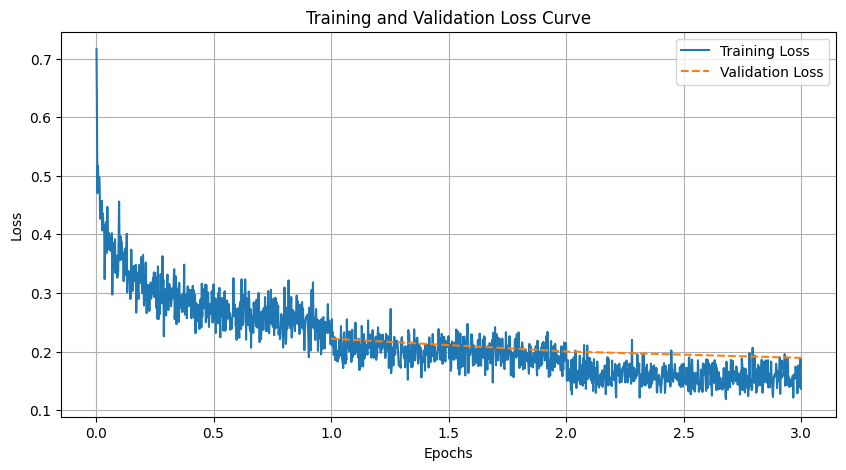

In [11]:
import matplotlib.pyplot as plt

def plot_loss(trainer):
    log_history = trainer.state.log_history
    
    # 提取训练集 loss
    train_steps = []
    train_loss = []
    
    # 提取验证集 loss
    eval_steps = []
    eval_loss = []
    
    for log in log_history:
        if "loss" in log and "epoch" in log:
            train_steps.append(log["epoch"])
            train_loss.append(log["loss"])
        if "eval_loss" in log and "epoch" in log:
            eval_steps.append(log["epoch"])
            eval_loss.append(log["eval_loss"])
            
    plt.figure(figsize=(10, 5))
    plt.plot(train_steps, train_loss, label="Training Loss")
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label="Validation Loss", linestyle='--')
        
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(trainer)

In [12]:
print(f"保存最终模型到: {OUTPUT_DIR}")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("Phase 2 - Step 1 (Structural Adaptation) 完成！")
print("您现在可以使用此模型进行下一阶段：使用标注数据进行 LoRA 微调 (Misconfig Detection)。")

保存最终模型到: /ssd_2t_1/wyq_workspace/genkubesect_structural_model
Phase 2 - Step 1 (Structural Adaptation) 完成！
您现在可以使用此模型进行下一阶段：使用标注数据进行 LoRA 微调 (Misconfig Detection)。


In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 1. 设置路径 (指向你训练好的 output_dir)
# 假设你最后保存的路径是这个，请根据实际情况修改
# MODEL_PATH = "/ssd_2t_1/wyq_workspace/genkubesect_structural_model" 
MODEL_PATH = "Salesforce/codet5p-770m"
# 如果你想对比，可以把这里改成 "Salesforce/codet5p-770m" 看看原始模型多“笨”

print(f"正在加载模型: {MODEL_PATH} ...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)

# 移到 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval() # 切换到评估模式

print("模型加载完成！开始测试...")

# ---------------------------------------------------------
# 定义推理函数
# ---------------------------------------------------------
def run_inference(prompt_text):
    # CodeT5p 的 Mask 标记通常是 <mask>，但 T5 预训练时内部其实是 <extra_id_0>
    # 为了验证你的训练成果（Masking 任务），我们模拟你在数据处理时的格式
    # 如果你在训练时直接用了 tokenizer.mask_token (<mask>)，这里也用 <mask>
    
    input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to(device)
    
    # 生成
    with torch.no_grad():
        outputs = model.generate(
            input_ids, 
            max_length=128, 
            num_beams=5,        # 使用 Beam Search 让结果更准
            early_stopping=True
        )
    
    # 解码
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output

# ---------------------------------------------------------
# 测试案例 (Case Studies)
# ---------------------------------------------------------

# Case 1: 预测关键字段 (Kind 推断)
# 也就是让模型猜：有了 apiVersion: v1，下面该接什么？
prompt_1 = "apiVersion: v1\nkind: <mask>\nmetadata:\n  name: my-test"
print(f"\n=== Case 1: 预测资源类型 ===\nInput:\n{prompt_1}")
print(f"Output: {run_inference(prompt_1)}")
# 预期输出: Pod, Service, Secret 等 v1 版本的资源，而不是 Deployment (apps/v1)

# Case 2: 预测属性值 (镜像推断)
# 让模型补全 nginx 的镜像版本
prompt_2 = "spec:\n  containers:\n  - name: nginx\n    image: nginx:<mask>\n    ports:"
print(f"\n=== Case 2: 预测镜像版本 ===\nInput:\n{prompt_2}")
print(f"Output: {run_inference(prompt_2)}")
# 预期输出: 1.14.2, latest, alpine 等常见 tag

# Case 3: 结构补全 (NSP/续写能力)
# 给个头，让它写尾巴。注意：CodeT5p 是 Seq2Seq，这里我们把 mask 放在最后
prompt_3 = "apiVersion: apps/v1\nkind: Deployment\nmetadata:\n  name: nginx-deployment\nspec:\n  replicas: 3\n  selector:\n    matchLabels:\n      app: nginx\n  template:\n    metadata:\n      labels:\n        app: nginx\n    spec:\n      containers:\n      - name: nginx\n        image: <mask>"
print(f"\n=== Case 3: 复杂结构补全 ===\nInput:\n{prompt_3}")
print(f"Output: {run_inference(prompt_3)}")
# 预期输出: 应该补全 image 的值，甚至可能顺带补全 ports 结构

正在加载模型: Salesforce/codet5p-770m ...
模型加载完成！开始测试...

=== Case 1: 预测资源类型 ===
Input:
apiVersion: v1
kind: <mask>
metadata:
  name: my-test
Output: /*
 * Licensed to the Apache Software Foundation (ASF) under one or more
 * contributor license agreements.  See the NOTICE file distributed with
 * this work for additional information regarding copyright ownership.
 * The ASF licenses this file to You under the Apache License, Version 2.0
 * (the "License"); you may not use this file except in compliance with
 * the License.  You may obtain a copy of the License at
 *
 *      http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable

=== Case 2: 预测镜像版本 ===
Input:
spec:
  containers:
  - name: nginx
    image: nginx:<mask>
    ports:
Output: 
  - name: nginx
    image: nginx:nginx
    ports:
    - port: 80
    - port: 443
  - name: nginx
    image: nginx:nginx
    ports:
    - port: 80
    - port: 443
  - name: nginx
    image: nginx:nginx
    ports:
    - port: 80
    - p

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 1. 设置路径 (指向你训练好的 output_dir)
# 假设你最后保存的路径是这个，请根据实际情况修改
MODEL_PATH = "/ssd_2t_1/wyq_workspace/genkubesect_structural_model" 
# 如果你想对比，可以把这里改成 "Salesforce/codet5p-770m" 看看原始模型多“笨”

print(f"正在加载模型: {MODEL_PATH} ...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)

# 移到 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval() # 切换到评估模式

print("模型加载完成！开始测试...")

# ---------------------------------------------------------
# 定义推理函数
# ---------------------------------------------------------
def run_inference(prompt_text):
    # CodeT5p 的 Mask 标记通常是 <mask>，但 T5 预训练时内部其实是 <extra_id_0>
    # 为了验证你的训练成果（Masking 任务），我们模拟你在数据处理时的格式
    # 如果你在训练时直接用了 tokenizer.mask_token (<mask>)，这里也用 <mask>
    
    input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to(device)
    
    # 生成
    with torch.no_grad():
        outputs = model.generate(
            input_ids, 
            max_length=128, 
            num_beams=5,        # 使用 Beam Search 让结果更准
            early_stopping=True
        )
    
    # 解码
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output

# ---------------------------------------------------------
# 测试案例 (Case Studies)
# ---------------------------------------------------------

# Case 1: 预测关键字段 (Kind 推断)
# 也就是让模型猜：有了 apiVersion: v1，下面该接什么？
prompt_1 = "apiVersion: v1\nkind: <mask>\nmetadata:\n  name: my-test"
print(f"\n=== Case 1: 预测资源类型 ===\nInput:\n{prompt_1}")
print(f"Output: {run_inference(prompt_1)}")
# 预期输出: Pod, Service, Secret 等 v1 版本的资源，而不是 Deployment (apps/v1)

# Case 2: 预测属性值 (镜像推断)
# 让模型补全 nginx 的镜像版本
prompt_2 = "spec:\n  containers:\n  - name: nginx\n    image: nginx:<mask>\n    ports:"
print(f"\n=== Case 2: 预测镜像版本 ===\nInput:\n{prompt_2}")
print(f"Output: {run_inference(prompt_2)}")
# 预期输出: 1.14.2, latest, alpine 等常见 tag

# Case 3: 结构补全 (NSP/续写能力)
# 给个头，让它写尾巴。注意：CodeT5p 是 Seq2Seq，这里我们把 mask 放在最后
prompt_3 = "apiVersion: apps/v1\nkind: Deployment\nmetadata:\n  name: nginx-deployment\nspec:\n  replicas: 3\n  selector:\n    matchLabels:\n      app: nginx\n  template:\n    metadata:\n      labels:\n        app: nginx\n    spec:\n      containers:\n      - name: nginx\n        image: <mask>"
print(f"\n=== Case 3: 复杂结构补全 ===\nInput:\n{prompt_3}")
print(f"Output: {run_inference(prompt_3)}")
# 预期输出: 应该补全 image 的值，甚至可能顺带补全 ports 结构

正在加载模型: /ssd_2t_1/wyq_workspace/genkubesect_structural_model ...
模型加载完成！开始测试...

=== Case 1: 预测资源类型 ===
Input:
apiVersion: v1
kind: <mask>
metadata:
  name: my-test
Output: apiVersion: v1
kind: Namespace
metadata:
  name: my-test

=== Case 2: 预测镜像版本 ===
Input:
spec:
  containers:
  - name: nginx
    image: nginx:<mask>
    ports:
Output: spec:
  containers:
  - name: nginx
    image: nginx:latest
    ports:
    - containerPort: 80


=== Case 3: 复杂结构补全 ===
Input:
apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx-deployment
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: <mask>
Output: apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx-deployment
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image